# Chapter 5.1.2 

In this notebook, we present an exampe of a classical long-short portfolio method that buys the undervalued and sells the overvalued stocks. 
To illustrate the idea, the entire universe contains 10 stocks. We rank the assets by their momentum, go long the top X% (e.g. top 2), and short the bottom X%. Everything else has 0 weights. 




In [1]:
import os 
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(current_dir)
sys.path.append(project_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Utilis.metrics import report_metrics

In [2]:
df = pd.read_csv('../Data/portfolio_data.csv')
tickers = df.columns[1:11]
df = df[tickers]
df_returns = df.pct_change()
print(df.head())

   AAPL_Close  ABT_Close  AEP_Close  AXP_Close  BAC_Close  CI_Close  GD_Close  \
0    0.413273   3.558854   7.348503   3.790746   5.654089  4.483136  4.486895   
1    0.413273   3.558854   7.348503   3.770368   5.668118  4.473284  4.422966   
2    0.421482   3.515974   7.348503   3.729606   5.699232  4.473284  4.510147   
3    0.426980   3.530267   7.348503   3.668465   5.727515  4.473284  4.603138   
4    0.419650   3.515974   7.348503   3.709226   5.713376  4.453577  4.556640   

    GE_Close  HON_Close  MMM_Close  
0  24.949545   7.150837  11.076602  
1  24.949545   7.198722  11.211850  
2  25.062447   7.294494  11.036032  
3  24.912300   7.374300  11.049558  
4  25.101883   7.501997  10.968409  


In [3]:
def long_short_portfolio_weights(momentum_series, n_long=2, n_short=2):
    """
    Given a Series of momentum values for each asset at a point in time,
    returns a Series of portfolio weights (long or short).

    - Long the top n_long assets IF their momentum > 0, otherwise weight = 0.
    - Short the bottom n_short assets IF their momentum < 0, otherwise weight = 0.
    """
    ranked = momentum_series.dropna().sort_values(ascending=False)
    weights = pd.Series(data=0.0, index=momentum_series.index)
    
    if len(ranked) >= (n_long + n_short):
        top_assets = ranked.index[:n_long]
        for asset in top_assets:
            if momentum_series[asset] > 0:
                weights.loc[asset] = 1.0

        bottom_assets = ranked.index[-n_short:]
        for asset in bottom_assets:
            if momentum_series[asset] < 0:
                weights.loc[asset] = -1.0
    
    return weights


In [4]:
# obtain momentum for each asset
lookback = 252
df_momentum = df / df.shift(lookback) - 1

# long the top 2 and short the bottom 2
df_weights = df_momentum.apply(
    lambda row: long_short_portfolio_weights(row, n_long=2, n_short=2), axis=1
).shift(1)
df_weights = df_weights.fillna(0.0)

# obtain daily return and cumsum return
portfolio_daily_returns = (df_weights * df_returns).sum(axis=1)
portfolio_cum_returns = portfolio_daily_returns.cumsum()


In [5]:
# For reference, let's suppose we just equally held all assets long (100% / 10 assets).
# We'll compare how that does vs. the cross-sectional momentum.
equal_weight_daily_returns = df_returns.mean(axis=1)
equal_weight_cum_return = equal_weight_daily_returns.cumsum()

In [6]:
print(report_metrics(equal_weight_daily_returns))
print(report_metrics(portfolio_daily_returns))


{'annual_ret': np.float64(0.16177468416633412), 'annual_std': np.float64(0.20494390574673016), 'annual_sharpe': np.float64(0.7893607940030938)}
{'annual_ret': np.float64(0.050896234804590476), 'annual_std': np.float64(0.6955285136308429), 'annual_sharpe': np.float64(0.07317634547992671)}


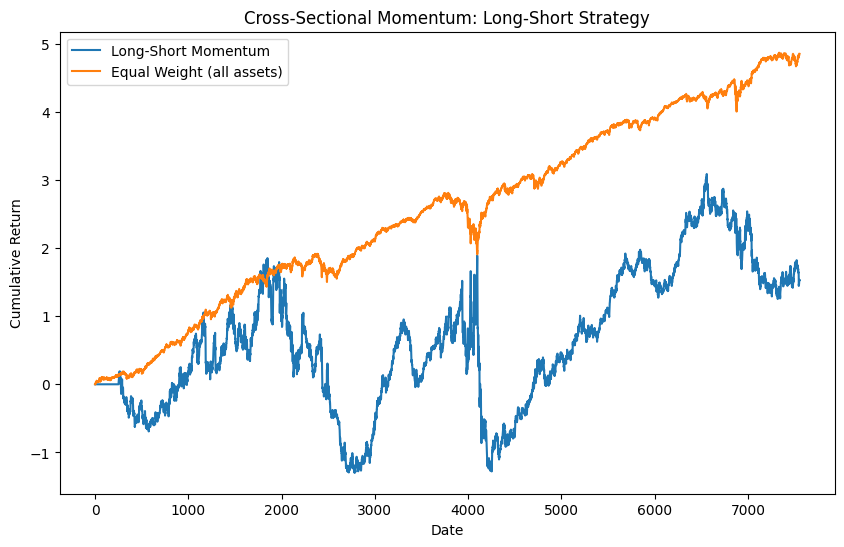

In [7]:
plt.figure(figsize=(10,6))
plt.plot(portfolio_cum_returns, label='Long-Short Momentum')
plt.plot(equal_weight_cum_return, label='Equal Weight (all assets)')
plt.title('Cross-Sectional Momentum: Long-Short Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()